# Alignment

In [1]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

In [2]:
import numpy as np
import cv2
import scipy.sparse
from tqdm import tqdm

from ipywidgets import interact, widgets

import sparse
import torch
import spconv.pytorch as spconv
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
import multiprocessing as mp
import os
import hashlib
from pathlib import Path
import copy
import pickle
import matplotlib.pyplot as plt

import sys

import torchvision

method='createOptFlow_DeepFlow'
kwargs_method=None
return_sparse=True
normalize=True

In [3]:
dir_github = Path(r'/n/data1/hms/neurobio/sabatini/gyu/github_clone').resolve()

sys.path.append(str(dir_github))

%load_ext autoreload
%autoreload 2
from ROICaT.tracking import data_importing, visualization, alignment, blurring, helpers, ROInet, scatteringWaveletTransformer, similarity_graph, cluster_assignment

In [ ]:
# simulated data

In [ ]:
dir_sf = "/n/data1/hms/neurobio/sabatini/gyu/github_clone/ROICaT_paper/data_Valerio_email4_SFandFOV/data.rbp10.plane0.npz"
file = np.load(dir_sf, allow_pickle=True)
ROIs = file['spatialFootprints'][:3]

In [4]:
dir_sf = "/n/data1/hms/neurobio/sabatini/gyu/github_clone/ROICaT_paper/data_Valerio_email4_SFandFOV/data.rbp10.plane0.npz"
file = np.load(dir_sf, allow_pickle=True)
ROIs = file['spatialFootprints'][:3]
FOVs = file['FOVs'][:3]
templateFOV = FOVs[0]

In [5]:
dims = templateFOV.shape
x_grid, y_grid = np.meshgrid(np.arange(0., dims[1]).astype(np.float32), np.arange(0., dims[0]).astype(np.float32))

In [6]:
template_norm = np.uint8(templateFOV * (templateFOV > 0) * (1/templateFOV.max()) * 255)
FOVs_norm    = [np.uint8(FOVs[ii] * (FOVs[ii] > 0) * (1/FOVs[ii].max()) * 255) for ii in range(len(FOVs))]

In [7]:
def safe_ROI_remap(img_ROI, x_remap, y_remap):
    img_ROI_remap = cv2.remap(
        img_ROI.astype(np.float32),
        x_remap,
        y_remap, 
        cv2.INTER_LINEAR
    )
    if img_ROI_remap.sum() == 0:
        img_ROI_remap = img_ROI
    return img_ROI_remap

In [8]:
ROIs_aligned, FOVs_aligned, flows = [], [], []

In [9]:
for ii in tqdm(range(len(FOVs)), mininterval=60):
            if method == 'createOptFlow_DeepFlow':
                flow = cv2.optflow.createOptFlow_DeepFlow().calc(
                    template_norm,
                    FOVs_norm[ii],
                    None
                )
                
            x_remap = (flow[:, :, 0] + x_grid).astype(np.float32)
            y_remap = (flow[:, :, 1] + y_grid).astype(np.float32)

            rois_toUse = ROIs[ii].toarray().astype(np.float32).reshape(ROIs[ii].shape[0], FOVs[ii].shape[0], FOVs[ii].shape[1]) if type(ROIs[ii]) is scipy.sparse.csr_matrix else ROIs[ii].astype(np.float32)

            ROI_aligned = np.stack([safe_ROI_remap(img, x_remap, y_remap) for img in rois_toUse], axis=0)
    #         ROI_aligned = np.stack([img.astype(np.float32) for img in ROIs[ii]], axis=0)
            FOV_aligned = cv2.remap(FOVs_norm[ii], x_remap, y_remap, cv2.INTER_NEAREST)

            if normalize:
                ROI_aligned = ROI_aligned / np.sum(ROI_aligned, axis=(1,2), keepdims=True)
            
            if return_sparse:
                ROIs_aligned.append(scipy.sparse.csr_matrix(ROI_aligned.reshape(ROI_aligned.shape[0], -1)))
                FOVs_aligned.append(FOV_aligned)
                flows.append(flow)
            else:
                ROIs_aligned.append(ROI_aligned)
                FOVs_aligned.append(FOV_aligned)
                flows.append(flow)

            ## remove NaNs from ROIs
            for ii in range(len(ROIs_aligned)):
                ROIs_aligned[ii].data[np.isnan(ROIs_aligned[ii].data)] = 0

100%|██████████| 3/3 [01:11<00:00, 23.93s/it]


In [ ]:
len(ROI_aligned)

In [ ]:
ROI_aligned[0].shape

In [11]:
test_images = [testsf.toarray().sum(0).reshape([512, 705]) for testsf in ROI_aligned]

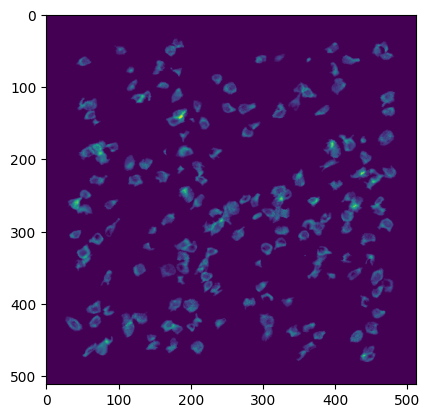

interactive(children=(IntSlider(value=0, description='i_frame', max=2), Output()), _dom_classes=('widget-inter…

In [12]:
fig = plt.figure()
ax = fig.add_subplot()
imshow_FOV = ax.imshow(test_images[0])

def update(i_frame = 0):
    fig.canvas.draw_idle()
    imshow_FOV.set_data(test_images[i_frame])

interact(update, i_frame=widgets.IntSlider(min=0, max=len(test_images)-1, step=1, value=0));

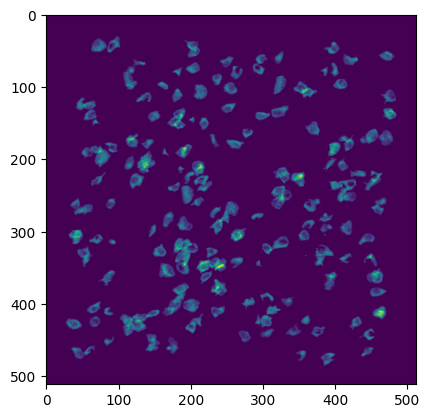

In [13]:
plt.imshow(test_images[2])

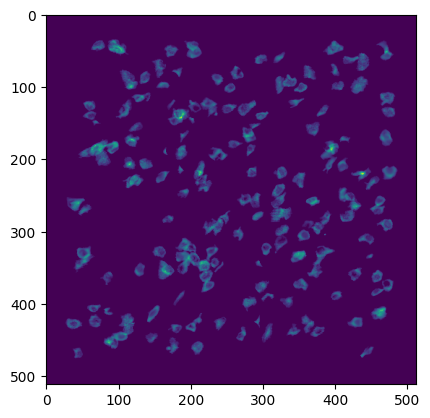

In [14]:
plt.imshow(test_images[1])

# Blurring

In [ ]:
# frame_shape=(dims[0], dims[1])
# kernel_halfWidth=1.4
# device='cuda:0'
# plot_kernel=False

In [ ]:
# width = kernel_halfWidth * 2
# kernel_size = int((width//2)*2) + 3

In [ ]:
# def cosine_kernel_2D(center=(5,5), image_size=(11,11), width=5):
#     """
#     Generate a 2D cosine kernel
#     RH 2021
    
#     Args:
#         center (tuple):  
#             The mean position (X, Y) - where high value expected. 0-indexed. Make second value 0 to make 1D
#         image_size (tuple): 
#             The total image size (width, height). Make second value 0 to make 1D
#         width (scalar): 
#             The full width of one cycle of the cosine
    
#     Return:
#         k_cos (np.ndarray): 
#             2D or 1D array of the cosine kernel
#     """
#     x, y = np.meshgrid(range(image_size[1]), range(image_size[0]))  # note dim 1:X and dim 2:Y
#     dist = np.sqrt((y - int(center[1])) ** 2 + (x - int(center[0])) ** 2)
#     dist_scaled = (dist/(width/2))*np.pi
#     dist_scaled[np.abs(dist_scaled > np.pi)] = np.pi
#     k_cos = (np.cos(dist_scaled) + 1)/2
#     return k_cos

In [ ]:
# kernel_tmp = cosine_kernel_2D(
#         center=(kernel_size//2, kernel_size//2), 
#         image_size=(kernel_size, kernel_size),
#         width=width
#     )

In [ ]:
# plt.imshow(kernel_tmp)

In [ ]:
# kernel = kernel_tmp / kernel_tmp.sum()

In [ ]:
# plt.imshow(kernel)

In [ ]:
# kernel_prep = torch.as_tensor(
#             kernel[:,:,None,None], 
#             dtype=torch.float32,
#             device=device
#         ).contiguous()

In [ ]:
# conv = spconv.SparseConv2d(
#             in_channels=1, 
#             out_channels=1,
#             kernel_size=kernel.shape, 
#             stride=1, 
#             padding=kernel.shape[0]//2, 
#             dilation=1, 
#             groups=1, 
#             bias=False
#         )

In [ ]:
# conv.weight = torch.nn.Parameter(data=kernel_prep, requires_grad=False)

In [ ]:
# spatialFootprints = ROIs_aligned
# batch_size=2000
# num_batches=100

In [ ]:
# sf_coo = [sparse.as_coo(sf).reshape((sf.shape[0], frame_shape[0], frame_shape[1])) for sf in spatialFootprints]

In [ ]:
# def _sparse_conv2D(sf_sparseCOO):
#         """
#         Method to perform a 2D convolution on a sparse matrix.

#         Args:
#             sf_sparseCOO (sparse.COO):
#                 The sparse matrix to convolve.
#                 shape: (num_ROIs, frame_shape[0], frame_shape[1])
#         """
#         images_spconv = pydata_sparse_to_spconv(
#             sf_sparseCOO,
#             device=device
#         )

#         images_conv = conv(images_spconv)
#         return sparse_convert_spconv_to_scipy(images_conv)

In [ ]:
# def make_batches(iterable, batch_size=None, num_batches=None, min_batch_size=0, return_idx=False, length=None):
#     """
#     Make batches of data or any other iterable.
#     RH 2021

#     Args:
#         iterable (iterable):
#             iterable to be batched
#         batch_size (int):
#             size of each batch
#             if None, then batch_size based on num_batches
#         num_batches (int):
#             number of batches to make
#         min_batch_size (int):
#             minimum size of each batch
#         return_idx (bool):
#             whether to return the indices of the batches.
#             output will be [start, end] idx
#         length (int):
#             length of the iterable.
#             if None, then length is len(iterable)
#             This is useful if you want to make batches of 
#              something that doesn't have a __len__ method.
    
#     Returns:
#         output (iterable):
#             batches of iterable
#     """

#     if length is None:
#         l = len(iterable)
#     else:
#         l = length
    
#     if batch_size is None:
#         batch_size = np.int64(np.ceil(l / num_batches))
    
#     for start in range(0, l, batch_size):
#         end = min(start + batch_size, l)
#         if (end-start) < min_batch_size:
#             break
#         else:
#             if return_idx:
#                 yield iterable[start:end], [start, end]
#             else:
#                 yield iterable[start:end]

In [ ]:
# def pydata_sparse_to_spconv(sp_array, device='cpu'):
#     coo = sparse.COO(sp_array)
#     idx_raw = torch.as_tensor(coo.coords.T, dtype=torch.int32, device=device).contiguous()
#     spconv_array = spconv.SparseConvTensor(
#         features=torch.as_tensor(coo.reshape((-1)).T.data, dtype=torch.float32, device=device)[:,None].contiguous(),
#         indices=idx_raw,
#         spatial_shape=coo.shape[1:], 
#         batch_size=coo.shape[0]
#     )
#     return spconv_array

In [ ]:
# def sparse_convert_spconv_to_scipy(sp_arr):
#     coo = sparse.COO(
#         coords=sp_arr.indices.T.to('cpu'),
#         data=sp_arr.features.squeeze().to('cpu'),
#         shape=[sp_arr.batch_size] + sp_arr.spatial_shape
#     )
#     return coo.reshape((coo.shape[0], -1)).to_scipy_sparse().tocsr()

In [ ]:
# ROIs_blurred = [scipy.sparse.vstack([_sparse_conv2D(
#             sf_sparseCOO=batch, 
#         ) for batch in make_batches(sf, batch_size=batch_size, num_batches=num_batches)]) for sf in sf_coo]

Sth is wrong on my side?

# Neural network embedding distances

In [10]:
hash_dict_true = {
    'params': ('params.json', '877e17df8fa511a03bc99cd507a54403'),
    'model': ('model.py', '6ef5c29793ae16a64e43e8cab33d9ff4'),
    'state_dict': ('ConvNext_tiny__1_0_unfrozen__simCLR.pth', 'a5fae4c9ea95f2c78b4690222b2928a5'),
}

In [11]:
pwd

'/n/data1/hms/neurobio/sabatini/gyu/github_clone/ROICaT/notebooks'

In [12]:
# dir_networkFiles='/n/data1/hms/neurobio/sabatini/gyu/github_clone/ROICaT/notebooks'
# gDriveID='1FCcPZUuOR7xG-hdO6Ei6mx8YnKysVsa8'

In [13]:
# sys.path.append(dir_networkFiles)
import model

In [14]:
import json
with open('/n/data1/hms/neurobio/sabatini/gyu/github_clone/ROICaT/notebooks/params.json') as f:
            params_model = json.load(f)
            net = model.make_model(params_model)

/home/gyh930/.conda/envs/ROICaT/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/gyh930/.conda/envs/ROICaT/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
for param in net.parameters():
    param.requires_grad = False
net.eval()

ModelTackOn(
  (base_model): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
          (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
        )
        (1): Sequential(
          (0): CNBlock(
            (block): Sequential(
              (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (1): Permute()
              (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
              (3): Linear(in_features=96, out_features=384, bias=True)
              (4): GELU(approximate=none)
              (5): Linear(in_features=384, out_features=96, bias=True)
              (6): Permute()
            )
            (stochastic_depth): StochasticDepth(p=0.0, mode=row)
          )
          (1): CNBlock(
            (block): Sequential(
              (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)


In [16]:
torchvision_model = params_model['torchvision_model']
n_block_toInclude = params_model['n_block_toInclude']
pre_head_fc_sizes = params_model['pre_head_fc_sizes']
post_head_fc_sizes = params_model['post_head_fc_sizes']
head_nonlinearity = params_model['head_nonlinearity']
image_shape = [3,224,224]

In [17]:
print(torchvision_model)
print(n_block_toInclude)
print(pre_head_fc_sizes)
print(post_head_fc_sizes)
print(head_nonlinearity)

convnext_tiny
7
[256]
[128]
GELU


In [18]:
base_model_frozen = torchvision.models.__dict__[torchvision_model](pretrained=True)

In [19]:
base_model_frozen

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate=none)
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96

In [20]:
model_chopped = torch.nn.Sequential(list(base_model_frozen.children())[0][:n_block_toInclude])

In [21]:
model_chopped_pooled = torch.nn.Sequential(model_chopped, torch.nn.AdaptiveAvgPool2d(output_size=1), torch.nn.Flatten())

In [22]:
model_chopped_pooled

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=96, out_features=384, bias=True)
            (4): GELU(approximate=none)
            (5): Linear(in_features=384, out_features=96, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,), eps=1e-06, e

In [23]:
data_dim = tuple([1] + image_shape)

In [24]:
model = model.ModelTackOn(
    #     model_chopped.to('cpu'),
        model_chopped_pooled.to('cpu'),
        base_model_frozen.to('cpu'),
        data_dim=data_dim,
        pre_head_fc_sizes=pre_head_fc_sizes, 
        post_head_fc_sizes=post_head_fc_sizes, 
        classifier_fc_sizes=None,
        nonlinearity=head_nonlinearity,
        kwargs_nonlinearity={},
    )

In [25]:
model.eval()

ModelTackOn(
  (base_model): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
          (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
        )
        (1): Sequential(
          (0): CNBlock(
            (block): Sequential(
              (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (1): Permute()
              (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
              (3): Linear(in_features=96, out_features=384, bias=True)
              (4): GELU(approximate=none)
              (5): Linear(in_features=384, out_features=96, bias=True)
              (6): Permute()
            )
            (stochastic_depth): StochasticDepth(p=0.0, mode=row)
          )
          (1): CNBlock(
            (block): Sequential(
              (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)


In [26]:
model_chopped_pooled(torch.rand(*(data_dim))).data.squeeze().shape[0]

768

In [27]:
model.prep_contrast()

In [28]:
model.eval()

ModelTackOn(
  (base_model): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
          (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
        )
        (1): Sequential(
          (0): CNBlock(
            (block): Sequential(
              (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (1): Permute()
              (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
              (3): Linear(in_features=96, out_features=384, bias=True)
              (4): GELU(approximate=none)
              (5): Linear(in_features=384, out_features=96, bias=True)
              (6): Permute()
            )
            (stochastic_depth): StochasticDepth(p=0.0, mode=row)
          )
          (1): CNBlock(
            (block): Sequential(
              (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)


In [29]:
model.forward

<bound method _forward_unimplemented of ModelTackOn(
  (base_model): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
          (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
        )
        (1): Sequential(
          (0): CNBlock(
            (block): Sequential(
              (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (1): Permute()
              (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
              (3): Linear(in_features=96, out_features=384, bias=True)
              (4): GELU(approximate=none)
              (5): Linear(in_features=384, out_features=96, bias=True)
              (6): Permute()
            )
            (stochastic_depth): StochasticDepth(p=0.0, mode=row)
          )
          (1): CNBlock(
            (block): Sequential(
              (0): Conv2d(96, 96, kernel_size=(7, 7), st

In [30]:
model.forward = model.forward_head

In [31]:
model.forward

<bound method ModelTackOn.forward_head of ModelTackOn(
  (base_model): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
          (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
        )
        (1): Sequential(
          (0): CNBlock(
            (block): Sequential(
              (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (1): Permute()
              (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
              (3): Linear(in_features=96, out_features=384, bias=True)
              (4): GELU(approximate=none)
              (5): Linear(in_features=384, out_features=96, bias=True)
              (6): Permute()
            )
            (stochastic_depth): StochasticDepth(p=0.0, mode=row)
          )
          (1): CNBlock(
            (block): Sequential(
              (0): Conv2d(96, 96, kernel_size=(7, 7), 

In [35]:
transforms = torch.nn.Sequential(
            ROInet.ScaleDynamicRange(scaler_bounds=(0,1)),
            torchvision.transforms.Resize(
                size=(224, 224),
                interpolation=torchvision.transforms.InterpolationMode.BILINEAR
            ), 
            ROInet.TileChannels(dim=0, n_channels=3),
        )

In [36]:
transforms

Sequential(
  (0): ScaleDynamicRange(scaler_bounds=(0, 1))
  (1): Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
  (2): TileChannels(dim=0)
)

In [37]:
transforms_scripted = torch.jit.script(transforms)

In [38]:
roinet = ROInet.ROInet_embedder(
    device='cuda:0',
    dir_networkFiles='/n/data1/hms/neurobio/sabatini/gyu/github_clone/ROICaT/notebooks',
    download_from_gDrive='check_local_first',
    gDriveID='1FCcPZUuOR7xG-hdO6Ei6mx8YnKysVsa8',
    hash_dict_networkFiles=hash_dict_true,
    verbose=True,
)

Successful hash comparison. Found matching files: {'params': '/n/data1/hms/neurobio/sabatini/gyu/github_clone/ROICaT/notebooks/params.json', 'model': '/n/data1/hms/neurobio/sabatini/gyu/github_clone/ROICaT/notebooks/model.py', 'state_dict': '/n/data1/hms/neurobio/sabatini/gyu/github_clone/ROICaT/notebooks/ConvNext_tiny__1_0_unfrozen__simCLR.pth'}
Imported model from /n/data1/hms/neurobio/sabatini/gyu/github_clone/ROICaT/notebooks/model.py
Loaded params_model from /n/data1/hms/neurobio/sabatini/gyu/github_clone/ROICaT/notebooks/params.json
Generated network using params_model
Loaded state_dict into network from /n/data1/hms/neurobio/sabatini/gyu/github_clone/ROICaT/notebooks/ConvNext_tiny__1_0_unfrozen__simCLR.pth
Loaded network onto device cuda:0


In [153]:
ROIs_aligned_np = [roisparse.toarray() for roisparse in ROIs_aligned]

In [152]:
ROIs_aligned[0].toarray().__array_interface__

{'data': (139917249892368, False),
 'strides': None,
 'descr': [('', '<f4')],
 'typestr': '<f4',
 'shape': (2775, 360960),
 'version': 3}

In [154]:
roinet.generate_dataloader(
    ROI_images=ROIs_aligned_np,
    um_per_pixel=1,
    pref_plot=False,
    batchSize_dataloader=8,
    pinMemory_dataloader=True,
    numWorkers_dataloader=mp.cpu_count(),
    persistentWorkers_dataloader=True,
    prefetchFactor_dataloader=2,    
);

Starting: resizing ROIs



100%|██████████| 3/3 [02:59<00:00, 59.76s/it]


Completed: resizing ROIs
Defined image transformations: Sequential(
  (0): ScaleDynamicRange(scaler_bounds=(0, 1))
  (1): Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
  (2): TileChannels(dim=0)
)
Defined dataset
Defined dataloader


In [156]:
roinet.ROI_images_rs.shape

(8993, 360960, 1)

In [157]:
roinet.generate_latents();

starting: running data through network



  0%|          | 0/1125 [00:00<?, ?it/s]/home/gyh930/.conda/envs/ROICaT/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %247 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/home/gyh930/.conda/envs/ROICaT/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %247 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/home/gyh930/.conda/envs/ROICaT/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %247 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  r

/home/gyh930/.conda/envs/ROICaT/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %247 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/home/gyh930/.conda/envs/ROICaT/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %247 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/home/gyh930/.conda/envs/ROICaT/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %247 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/hom

completed: running data through network


In [159]:
roinet.latents.size()

torch.Size([8993, 256])

# SWT

In [68]:
ROI_aligned.shape

(3201, 512, 705)

In [64]:
ROIs_aligned[0].shape

(2775, 360960)

In [66]:
ROIs_aligned[1].shape

(3017, 360960)

In [67]:
ROIs_aligned[2].shape

(3201, 360960)

In [69]:
swt = scatteringWaveletTransformer.SWT(
    kwargs_Scattering2D={'J': 2, 'L': 8}, 
    image_shape=ROI_aligned[0].shape[0:2], 
    device='cuda:0'
)

SWT initialized


In [71]:
swt.transform(
    ROI_images=np.concatenate(ROI_aligned, axis=0),
    batch_size=100,
);

Starting: SWT transform on ROIs


  0%|          | 0/16389.12 [00:00<?, ?it/s]

RuntimeError: Tensor must be of spatial size (512,705).

In [ ]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

# Similarity matrix

In [81]:
sim = similarity_graph.ROI_graph(
    device='cpu',
    n_workers=-1,
    spatialFootprint_maskPower=0.8,
    frame_height=512,
    frame_width=705,
    block_height=50,
    block_width=50,
    overlapping_width_Multiplier=0.1,
    algorithm_nearestNeigbors_spatialFootprints='brute',
    n_neighbors_nearestNeighbors_spatialFootprints='full',
    locality=1.0,
    verbose=True,
)

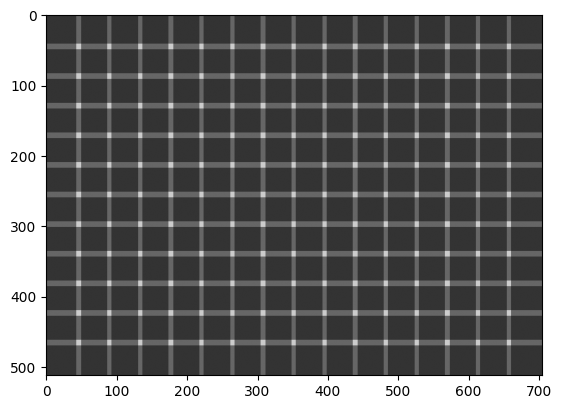

In [82]:
sim.visualize_blocks()

In [ ]:
sim.compute_similarity_blockwise(
    # spatialFootprints=blurrer.ROIs_blurred,
    spatialFootprints=ROIs_aligned,
    features_NN=roinet.latents,
    features_SWT=swt.latents,
    ROI_session_bool=data.sessionID_concat,
    linkage_methods=['single', 'complete', 'ward', 'average'],
    linkage_distances=helpers.bounded_logspace(0.02, 3, 70),
    min_cluster_size=3,
    max_cluster_size=None,
    batch_size_hashing=300,
);

In [145]:
ROIs_aligned[2].shape

(3201, 360960)

In [84]:
spatialFootprints = ROIs_aligned

In [85]:
sf_cat = scipy.sparse.vstack(spatialFootprints)

In [88]:
sf_cat.shape

(8993, 360960)

In [202]:
sim.idxPixels_block[3]

array([ 88830,  88831,  88832, ..., 123422, 123423, 123424])

In [183]:
idxROI_block = np.where(sf_cat[:, sim.idxPixels_block[3]].sum(1) > 0)[0]

In [184]:
len(idxROI_block)

82

In [185]:
features_NN = roinet.latents[idxROI_block]

In [186]:
features_NN.size()

torch.Size([82, 256])

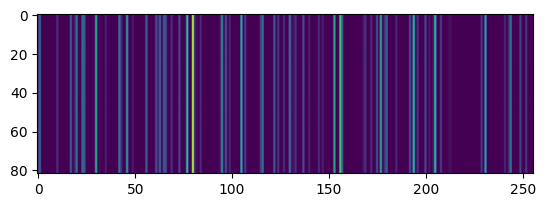

In [194]:
plt.imshow(features_NN)

In [187]:
d_NN  = torch.cdist(features_NN.to('cpu'),  features_NN.to('cpu'),  p=2).cpu()

In [188]:
d_NN.sum()

tensor(15189.4775)

In [227]:
s_NN = 1 / (d_NN / d_NN.max())
s_NN[s_NN < 0] = 0
s_NN[range(s_NN.shape[0]), range(s_NN.shape[0])] = 0

In [228]:
s_NN.shape

torch.Size([82, 82])

In [229]:
s_NN

tensor([[0.0000, 1.0474,    inf,  ...,    inf,    inf,    inf],
        [1.0474, 0.0000, 1.0474,  ..., 1.0474, 1.0474, 1.0474],
        [   inf, 1.0474, 0.0000,  ...,    inf,    inf,    inf],
        ...,
        [   inf, 1.0474,    inf,  ..., 0.0000,    inf,    inf],
        [   inf, 1.0474,    inf,  ...,    inf, 0.0000,    inf],
        [   inf, 1.0474,    inf,  ...,    inf,    inf, 0.0000]])

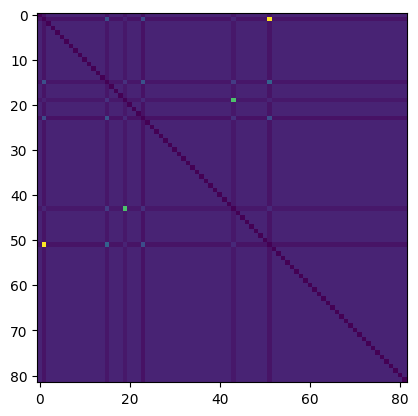

In [225]:
plt.imshow(s_NN)

In [199]:
spatialFootprints=sf_cat[idxROI_block][:, sim.idxPixels_block[3]].power(0.8)

In [200]:
spatialFootprints.shape

(82, 2500)

In [204]:
sf = scipy.sparse.vstack(spatialFootprints)
sf = sf.power(0.8)
sf = sf.multiply( 0.5 / sf.sum(1))
sf = scipy.sparse.csr_matrix(sf)

In [207]:
sf.sum(1)[0]

matrix([[0.50000006]], dtype=float32)

In [209]:
import sklearn
d_sf = sklearn.neighbors.NearestNeighbors(
            algorithm='brute',
            metric='manhattan',
            p=1,
            # n_jobs=self._n_workers,
            n_jobs=-1,
        ).fit(sf).kneighbors_graph(
            sf,
            n_neighbors=sf.shape[0],
            mode='distance'
        )

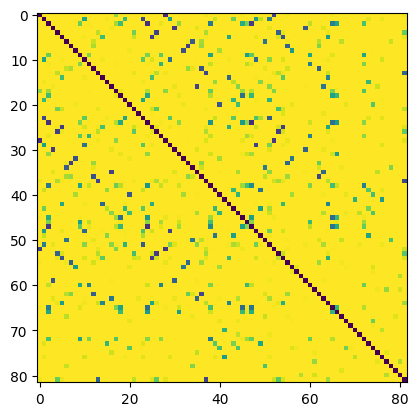

In [214]:
plt.imshow(d_sf.toarray())

In [231]:
s_sf = 1 - d_sf.toarray()
s_sf[s_sf < 1e-5] = 0  ## Likely due to numerical errors, some values are < 0 and very small. Rectify to fix.
s_sf[range(s_sf.shape[0]), range(s_sf.shape[0])] = 0
s_sf = torch.as_tensor(s_sf, dtype=torch.float32)

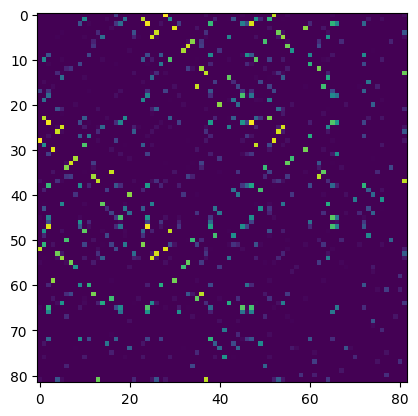

In [232]:
plt.imshow(s_sf)

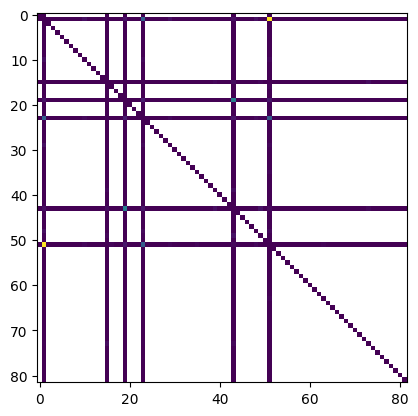

In [234]:
plt.imshow(s_sf * s_NN)